In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
# Hyperparameters
batch_size = 64
in_embed_dim = 100
out_embed_dim = 200
num_heads = 4
num_layers = 3
learning_rate = 3e-4
max_iters= 20000
eval_interval = 1000
eval_iters = 100

In [7]:
torch.manual_seed(19)
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [8]:
with open('cmudict-0.7b', 'rb') as f:
    data = f.readlines()
data = data[126:-5]
filtered_data = []
for i in range(len(data)):
    if i == 35606: continue
    filtered_data.append(data[i].decode())
with open('cmudict-0.7b.symbols') as f:
    symbols = f.read().splitlines()

In [9]:
spellings = []
pronounciations = []
for d in filtered_data:
    split = d.strip("\r\n").split()
    spellings.append(split[0])
    pronounciations.append(['#'] + split[1:] + ['#'])

In [10]:
# Remove words with numbers in them
for i, s in enumerate(spellings):
    if '(' not in s:
        if '1' in s or '2' in s or '3' in s or '4' in s or '5' in s or '6' in s or '7' in s or '8' in s or '9' in s or '0' in s:
            spellings.pop(i)
            pronounciations.pop(i)

In [11]:
# Don't track copies separately
for i, s in enumerate(spellings):
    spellings[i] = s.strip("(1234567890)")

(array([9.0780e+03, 6.4015e+04, 4.7315e+04, 1.2994e+04, 8.1500e+02,
        6.1000e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 1. ,  4.3,  7.6, 10.9, 14.2, 17.5, 20.8, 24.1, 27.4, 30.7, 34. ]),
 <BarContainer object of 10 artists>)

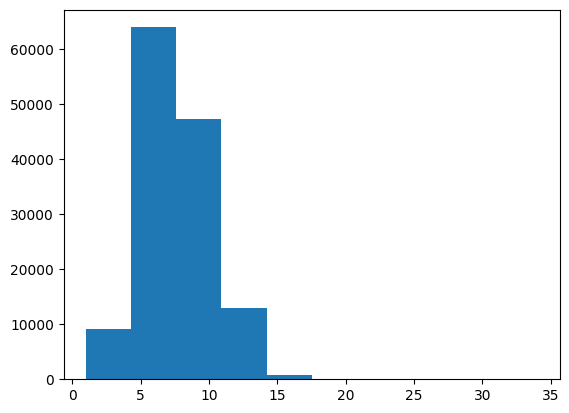

In [12]:
plt.hist([len(s) for s in spellings])

(array([2.4307e+04, 7.4347e+04, 2.9769e+04, 5.2750e+03, 5.4700e+02,
        3.3000e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 3. ,  6.1,  9.2, 12.3, 15.4, 18.5, 21.6, 24.7, 27.8, 30.9, 34. ]),
 <BarContainer object of 10 artists>)

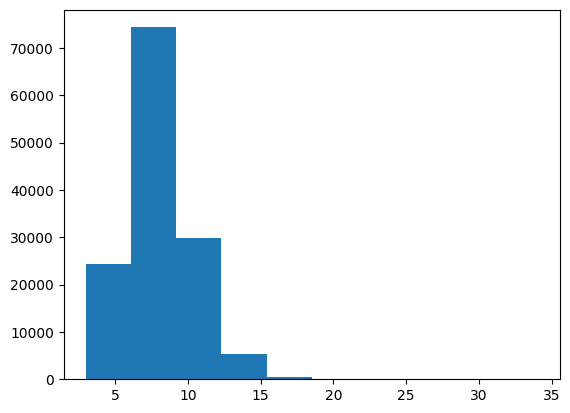

In [13]:
plt.hist([len(p) for p in pronounciations])

In [14]:
in_tokens = sorted(list(set(''.join(spellings))))
num_tokens = len(in_tokens) + 1
in_stoi = {s:i for i, s in enumerate(in_tokens, 1)}
in_stoi['#'] = 0
in_itos = {i:s for s, i in in_stoi.items()}

num_symbols = len(symbols) + 1
out_stoi = {s:i for i, s in enumerate(symbols, 1)}
out_stoi['#'] = 0
out_itos = {i:s for s, i in out_stoi.items()}

In [15]:
MAX_LENGTH = 20
spellings_padded = []
for s in spellings:
    if len(s) > MAX_LENGTH:
        spellings_padded.append([in_stoi[c] for c in s[:MAX_LENGTH]])
    else:
        a = [in_stoi[c] for c in s]
        for _ in range(MAX_LENGTH - len(a)):
            a.append(0)
        spellings_padded.append(a)

pronounciations_padded = []
for p in pronounciations:
    if len(p) > MAX_LENGTH + 1:
        pronounciations_padded.append([out_stoi[s] for s in p[:MAX_LENGTH+1]])
    else:
        a = [out_stoi[s] for s in p]
        for _ in range(MAX_LENGTH + 1 - len(a)):
            a.append(0)
        pronounciations_padded.append(a)

In [16]:
spellings = torch.tensor(spellings_padded, device=device)
pronounciations = torch.tensor(pronounciations_padded, device=device)
spellings_train, spellings_test, pronounciations_train, pronounciations_test = train_test_split(spellings, pronounciations, test_size=0.1, random_state=19)
spellings_train, spellings_val, pronounciations_train, pronounciations_val = train_test_split(spellings_train, pronounciations_train, test_size=0.15, random_state=19)

In [17]:
def get_batch(mode='train'):

    if mode == 'train':
        enc_data = spellings_train
        dec_data = pronounciations_train
    elif mode == 'val':
        enc_data = spellings_val
        dec_data = pronounciations_val
    elif mode == 'test':
        enc_data = spellings_test
        dec_data = pronounciations_test
    else:
        raise ValueError("Invalid Mode")

    idxs = torch.randint(enc_data.shape[0], (batch_size,))
    x_enc = enc_data[idxs]
    x_dec = dec_data[idxs][:, :MAX_LENGTH]
    y = dec_data[idxs][:, 1:]

    return x_enc, x_dec, y

In [18]:
class EncoderHead(nn.Module):

    def __init__(self, head_dim):
        super().__init__()

        self.q = nn.Linear(in_embed_dim, head_dim, bias=False)
        self.k = nn.Linear(in_embed_dim, head_dim, bias=False)
        self.v = nn.Linear(in_embed_dim, head_dim, bias=False)

    def forward(self, x):
        # print('X shape:', x.shape)
        q = self.q(x)
        k = self.k(x)
        qkt = q @ k.transpose(-1, -2) / (k.shape[-1]**0.5)
        qkt_softmax = F.softmax(qkt, dim=-1)
        v = self.v(x)
        return qkt_softmax @ v

In [19]:
class DecoderHead(nn.Module):

    def __init__(self, head_dim):
        super().__init__()

        self.q = nn.Linear(out_embed_dim, head_dim, bias=False)
        self.k = nn.Linear(out_embed_dim, head_dim, bias=False)
        self.v = nn.Linear(out_embed_dim, head_dim, bias=False)
        self.register_buffer('mask', torch.tril(torch.ones(MAX_LENGTH, MAX_LENGTH)))

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        # print('q:', q.shape)
        # print('k:', k.shape)
        _, time_dim, head_dim = k.shape
        # print('head_dim:', head_dim)
        # print('kt:', k.transpose(-1, -2).shape)
        qkt = q @ k.transpose(-1, -2) / (head_dim**0.5)
        # print('qkt:', qkt.shape)
        qkt = qkt.masked_fill(self.mask[:time_dim, :time_dim] == 0, float('-inf'))
        qkt_softmax = F.softmax(qkt, dim=-1)
        v = self.v(x)
        return qkt_softmax @ v

In [20]:
class CrossAttentionHead(nn.Module):

    def __init__(self, head_dim):
        super().__init__()

        self.q = nn.Linear(out_embed_dim, head_dim, bias=False)
        self.k = nn.Linear(in_embed_dim, head_dim, bias=False)
        self.v = nn.Linear(in_embed_dim, head_dim, bias=False)

    def forward(self, x_enc, x_dec):
        q = self.q(x_dec)
        k = self.k(x_enc)
        qkt = q @ k.transpose(-1, -2) / (k.shape[-1]**0.5)
        qkt_softmax = F.softmax(qkt, dim=-1)
        v = self.v(x_enc)
        return qkt_softmax @ v

In [21]:
class MultiHead(nn.Module):

    def __init__(self, num_heads, head_size, is_encoder):
        super().__init__()

        if is_encoder:
            self.heads = nn.ModuleList([EncoderHead(head_size) for _ in range(num_heads)])
            self.proj = nn.Linear(head_size * num_heads, in_embed_dim)
        else:
            self.heads = nn.ModuleList([DecoderHead(head_size) for _ in range(num_heads)])
            self.proj = nn.Linear(head_size * num_heads, out_embed_dim)

    def forward(self, x):
        # print("MULTIHEAD")
        # os = []
        # for h in self.heads:
        #   o = h(x)
        #   print(o.shape)
        #   os.append(o)
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return self.proj(out)

In [22]:
class MultiCrossHead(nn.Module):

    def __init__(self, num_heads, head_size):
        super().__init__()

        self.heads = nn.ModuleList([CrossAttentionHead(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, out_embed_dim)

    def forward(self, x_enc, x_dec):
        out = torch.cat([h(x_enc, x_dec) for h in self.heads], dim=-1)
        return self.proj(out)

In [23]:
class FeedForward(nn.Module):

    def __init__(self, embed_dim):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.ReLU(),
            nn.Linear(4 * embed_dim, embed_dim)
        )

    def forward(self, x):
        return self.layers(x)

In [24]:
class EncoderBlock(nn.Module):

    def __init__(self):
        super().__init__()

        head_size = in_embed_dim // num_heads

        self.mha = MultiHead(num_heads, head_size, True)
        self.ln1 = nn.LayerNorm(in_embed_dim)
        self.ffnn = FeedForward(in_embed_dim)
        self.ln2 = nn.LayerNorm(in_embed_dim)

    def forward(self, x):

        mhout = self.mha(x)
        x = self.ln1(x + mhout)
        ffout = self.ffnn(x)
        return self.ln2(x + ffout)

In [25]:
class DecoderBlock(nn.Module):

    def __init__(self):
        super().__init__()

        head_size = out_embed_dim // num_heads

        self.mha = MultiHead(num_heads, head_size, False)
        self.ln1 = nn.LayerNorm(out_embed_dim)
        self.ca = MultiCrossHead(num_heads, head_size)
        self.ln2 = nn.LayerNorm(out_embed_dim)
        self.ffnn = FeedForward(out_embed_dim)
        self.ln3 = nn.LayerNorm(out_embed_dim)

    def forward(self, x_enc, x_dec):
        mhout = self.mha(x_dec)
        x_dec = self.ln1(x_dec + mhout)
        caout = self.ca(x_enc, x_dec)
        x_dec = self.ln2(x_dec + caout)
        ffout = self.ffnn(x_dec)
        return self.ln3(x_dec + ffout)

In [26]:
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.token_embedding = nn.Embedding(num_tokens, in_embed_dim)
        self.position_embedding = nn.Embedding(MAX_LENGTH, in_embed_dim)
        self.blocks = nn.Sequential(*[EncoderBlock() for _ in range(num_layers)])

    def forward(self, x):
        token_embed = self.token_embedding(x)
        # print(token_embed.shape)
        b = torch.arange(x.shape[1], device=device)
        # print(b.shape)
        pos_embed = self.position_embedding(b)
        x = token_embed + pos_embed
        return self.blocks(x)

In [27]:
class Decoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.token_embedding = nn.Embedding(num_symbols, out_embed_dim)
        self.position_embedding = nn.Embedding(MAX_LENGTH, out_embed_dim)
        # self.blocks = nn.Sequential(*[DecoderBlock() for _ in range(num_layers)])
        self.db1 = DecoderBlock()
        self.db2 = DecoderBlock()
        self.db3 = DecoderBlock()

    def forward(self, x_enc, x_dec):
        # print(x_dec.shape)
        token_embed = self.token_embedding(x_dec)
        # print(token_embed.shape)
        b = torch.arange(x_dec.shape[1], device=device)
        # print(b.shape)
        pos_embed = self.position_embedding(b)
        x_dec = token_embed + pos_embed
        # x_dec = self.token_embedding(x_dec) + self.position_embedding(torch.arange(x_dec.shape[1], device=device))
        x_dec = self.db1(x_enc, x_dec)
        x_dec = self.db2(x_enc, x_dec)
        x_dec = self.db3(x_enc, x_dec)
        return x_dec

In [28]:
class Transformer(nn.Module):

    def __init__(self):
        super().__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()
        self.head = nn.Linear(out_embed_dim, num_symbols)

    def forward(self, spelling, pronounciation, target=None):
        x_enc = self.encoder(spelling)
        x_dec = self.decoder(x_enc, pronounciation)
        logits = self.head(x_dec)

        if target==None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            target = target.reshape(B*T)
            loss = F.cross_entropy(logits, target)

        return logits, loss

    def generate(self, spelling):
        pronounciation = torch.zeros((spelling.shape[0], 1), device=device)
        while(True):
            logits, loss = self(spelling, pronounciation)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_symb = torch.multinomial(probs, num_samples=1)
            pronounciation = torch.cat((pronounciation, next_symb), dim=1)
            if next_symb[0] == 0:
                return pronounciation

In [29]:
model = Transformer().to(device)
print('Number of Parameters:', sum(p.numel() for p in model.parameters()))

Number of Parameters: 2213985


In [30]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [31]:
for iter in range(max_iters):

    xb_enc, xb_dec, yb = get_batch('train')

    logits, loss = model(xb_enc, xb_dec, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if iter % eval_interval == 0 or iter == max_iters - 1:
        # losses = estimate_loss()
        print(f"step {iter}: train loss {loss:.4f}")

step 0: train loss 4.4508
step 1000: train loss 0.1717
step 2000: train loss 0.1452
step 3000: train loss 0.1297
step 4000: train loss 0.1094
step 5000: train loss 0.0917
step 6000: train loss 0.1015
step 7000: train loss 0.0900
step 8000: train loss 0.1046
step 9000: train loss 0.0763
step 10000: train loss 0.1079
step 11000: train loss 0.0642
step 12000: train loss 0.0659
step 13000: train loss 0.0681
step 14000: train loss 0.0675
step 15000: train loss 0.0444
step 16000: train loss 0.0655
step 17000: train loss 0.0540
step 18000: train loss 0.0598
step 19000: train loss 0.0653
step 19999: train loss 0.0469


In [32]:
@torch.no_grad()
def get_loss(mode, model):
    if mode == 'train':
        enc_data = spellings_train
        dec_data = pronounciations_train
    elif mode == 'val':
        enc_data = spellings_val
        dec_data = pronounciations_val
    elif mode == 'test':
        enc_data = spellings_test
        dec_data = pronounciations_test
    else:
        raise ValueError("Invalid Mode")

    x_enc = enc_data
    x_dec = dec_data[:, :MAX_LENGTH]
    y = dec_data[:, 1:]
    _, loss = model(x_enc, x_dec, y)
    return loss

In [33]:
get_loss('val', model)

tensor(0.1026, device='cuda:0')

In [34]:
get_loss('test', model)

tensor(0.1006, device='cuda:0')